In [1]:
library(tidyverse)
library(arrow)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.0     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp




In [2]:

df_shinka <- as_tibble(read_parquet("shinka.parquet"))
df_shinka_scipy <- as_tibble(read_parquet("shinka_scipy.parquet"))
df_rayevolve <- as_tibble(read_parquet("rayevolve.parquet"))
df_rayevolve_scipy <- as_tibble(read_parquet("rayevolve_scipy.parquet"))

df_shinka <- df_shinka %>% filter(correct == TRUE)
df_shinka_scipy <- df_shinka_scipy %>% filter(correct == TRUE)

In [3]:
colnames(df_shinka)

[1] "id"                      "code"                   
 [3] "language"                "parent_id"              
 [5] "archive_inspiration_ids" "top_k_inspiration_ids"  
 [7] "generation"              "timestamp"              
 [9] "complexity"              "embedding"              
[11] "code_diff"               "correct"                
[13] "combined_score"          "compute_time"           
[15] "api_costs"               "embed_cost"             
[17] "novelty_cost"            "patch_type"             
[19] "patch_name"              "patch_description"      
[21] "stdout_log"              "stderr_log"             
[23] "code_analysis_metrics"   "centers_str"            
[25] "num_circles"             "reported_sum_of_radii"  
[27] "text_feedback"           "_is_island_copy"        
[29] "_original_program_id"    "num_applied"            
[31] "error_attempt"           "novelty_attempt"        
[33] "resample_attempt"        "patch_attempt"          
[35] "model_name"              "temperature"            
[37] "max_tokens"              "llm_result"             
[39] "diff_summary"

In [4]:
add_best_score <- function(df, gen_col = "generation", score_col = "combined_score", best_col = "best_score") {
  gen_sym   <- rlang::sym(gen_col)
  score_sym <- rlang::sym(score_col)
  best_sym  <- rlang::sym(best_col)

  # Sort by generation
  df_sorted <- dplyr::arrange(df, !!gen_sym)

  # Per-generation max, then cumulative best across generations
  gen_best <- df_sorted %>%
    dplyr::group_by(!!gen_sym) %>%
    dplyr::summarise(gen_max = max(!!score_sym, na.rm = TRUE), .groups = "drop") %>%
    dplyr::mutate(
      # Treat -Inf (all NA) as NA before cummax
      gen_max = dplyr::if_else(is.infinite(gen_max), NA_real_, gen_max),
      !!best_sym := cummax(dplyr::coalesce(gen_max, -Inf)),
      !!best_sym := dplyr::na_if(!!best_sym, -Inf)
    ) %>%
    dplyr::select(!!gen_sym, !!best_sym)

  # Attach best_score to all rows for that generation
  df_sorted %>% dplyr::left_join(gen_best, by = gen_col)
}

# Example usage:
df_shinka <- add_best_score(df_shinka)
df_shinka_scipy <- add_best_score(df_shinka_scipy)
df_rayevolve <- add_best_score(df_rayevolve)
df_rayevolve_scipy <- add_best_score(df_rayevolve_scipy)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_point()`).”


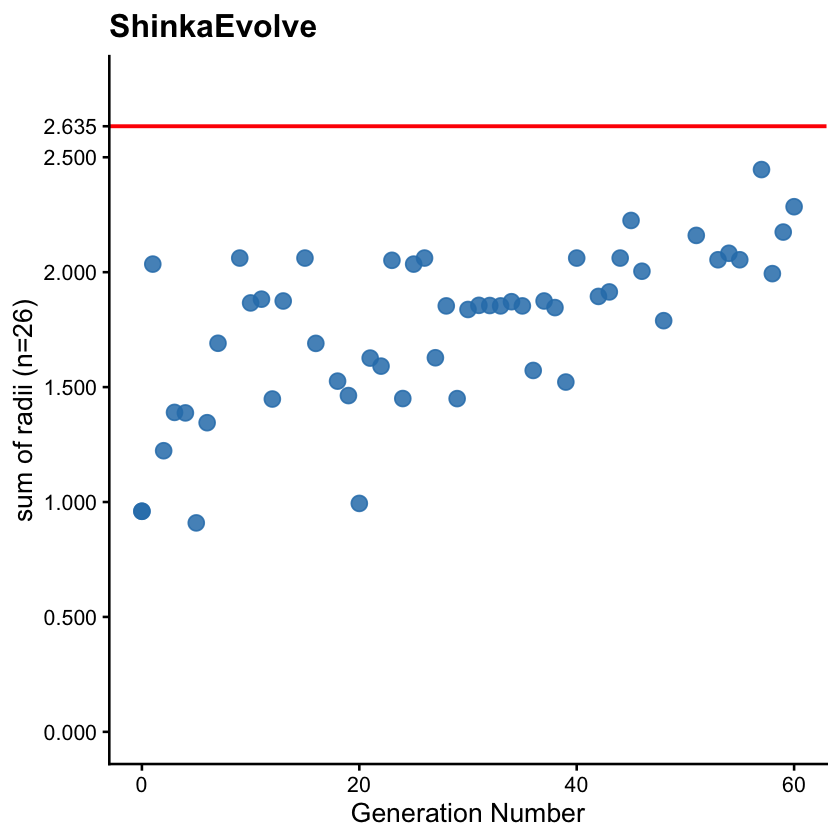

Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”


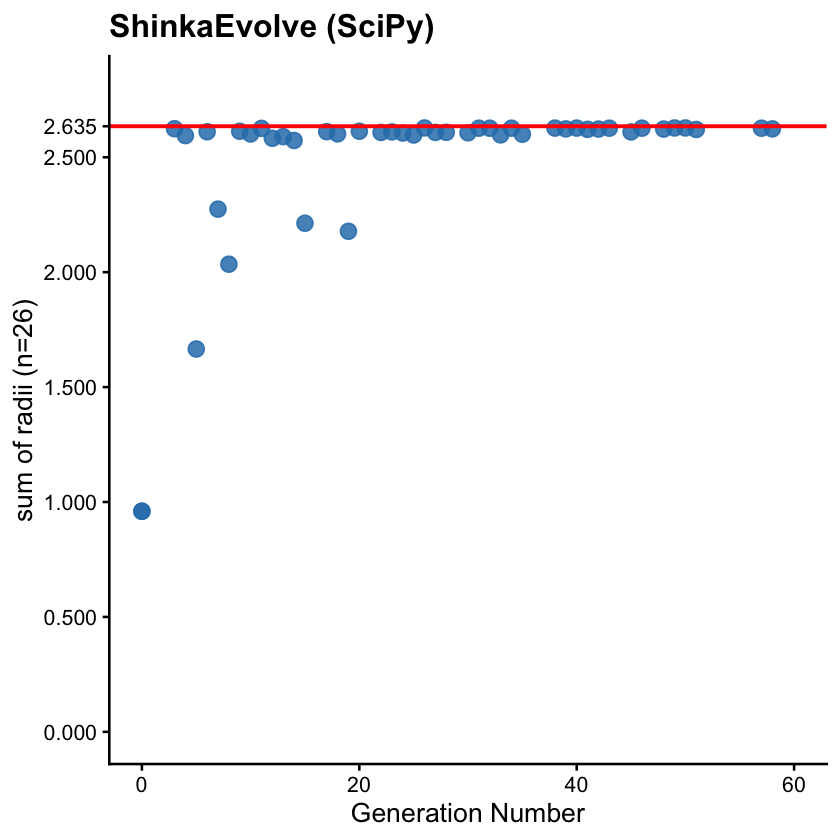

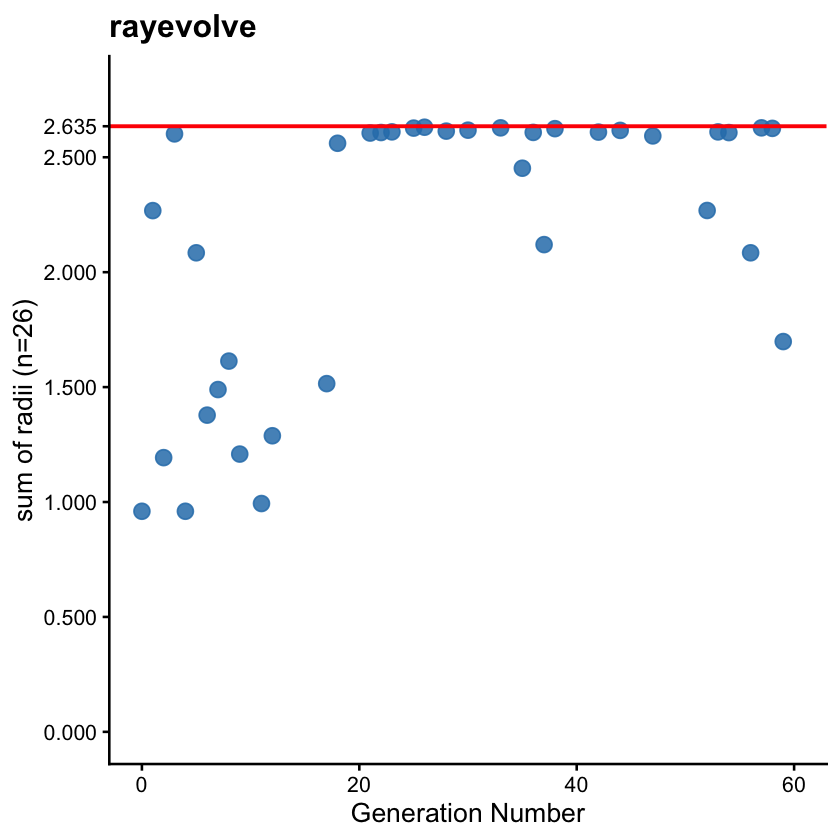

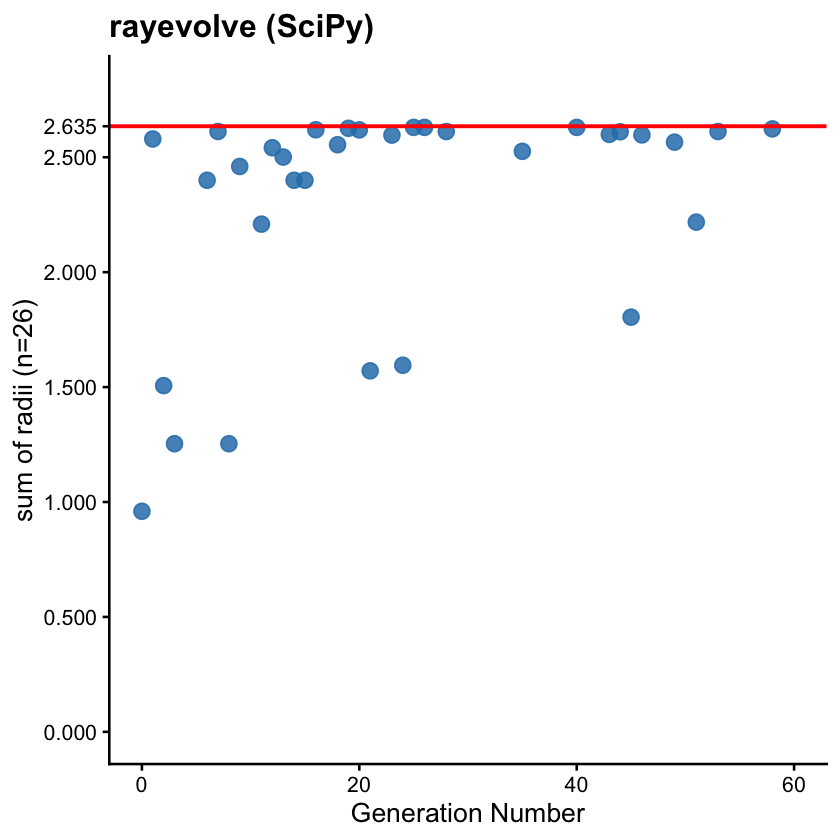

In [5]:

# Reusable plot function
plot_gen_vs_score <- function(df,
                              title = "Generation vs Combined Score",
                              gen_col = "generation",
                              score_col = "combined_score",
                              best_col = "best_score",
                              y_lim = c(0, 2.8),
                              point_size = 4.0,
                              line_size = 1.1,
                              base_size = 16,
                              y_breaks_n = 10,
                              max_gen = 60) {

  gen_sym   <- rlang::sym(gen_col)
  score_sym <- rlang::sym(score_col)
  best_sym  <- rlang::sym(best_col)

  points_df <- df %>% dplyr::filter(!is.na(!!gen_sym), !is.na(!!score_sym))

  p <- ggplot2::ggplot(points_df, ggplot2::aes(x = !!gen_sym, y = !!score_sym)) +
    ggplot2::geom_point(alpha = 0.85, color = "#2C7FB8", size = point_size) +
    ggplot2::geom_hline(yintercept = 2.635, color = "red", size = line_size) +
    ggplot2::labs(
      title = title,
      x = "Generation Number",
      y = "sum of radii (n=26)"
    ) +
    ggplot2::theme_classic(base_size = base_size) +
    ggplot2::theme(
      axis.line  = ggplot2::element_line(color = "black"),
      axis.ticks = ggplot2::element_line(color = "black"),
      axis.text  = ggplot2::element_text(color = "black"),
      axis.title = ggplot2::element_text(color = "black"),
      plot.title = ggplot2::element_text(face = "bold")
    )

  # Add y-axis ticks density control and force a tick at 2.635
  y_breaks_fun <- function(lims) {
    sort(unique(c(scales::pretty_breaks(n = y_breaks_n)(lims), 2.635)))
  }
  if (is.null(y_lim)) {
    p <- p + ggplot2::scale_y_continuous(breaks = y_breaks_fun)
  } else {
    p <- p + ggplot2::scale_y_continuous(limits = range(c(y_lim, 2.635)), breaks = y_breaks_fun)
  }

  # Constrain x-axis to a maximum generation (default 70)
  p <- p + ggplot2::scale_x_continuous(limits = c(0, max_gen))

  p
}

# Usage
plot_gen_vs_score(df_shinka,       title = "ShinkaEvolve")
plot_gen_vs_score(df_shinka_scipy, title = "ShinkaEvolve (SciPy)")
plot_gen_vs_score(df_rayevolve,    title = "rayevolve")
plot_gen_vs_score(df_rayevolve_scipy,    title = "rayevolve (SciPy)")

In [6]:

df_shinka_uci <- as_tibble(read_parquet("shinka_uci_adult.parquet"))
df_rayevolve_uci <- as_tibble(read_parquet("rayevolve_uci_adult.parquet"))

df_shinka_uci <- df_shinka_uci %>% filter(correct == TRUE)
df_rayevolve_uci <- df_rayevolve_uci %>% filter(correct == TRUE)

In [7]:
df_shinka_uci <- add_best_score(df_shinka_uci)
df_rayevolve_uci <- add_best_score(df_rayevolve_uci)

Warning message:
“Removed 49 rows containing missing values or values outside the scale range (`geom_point()`).”


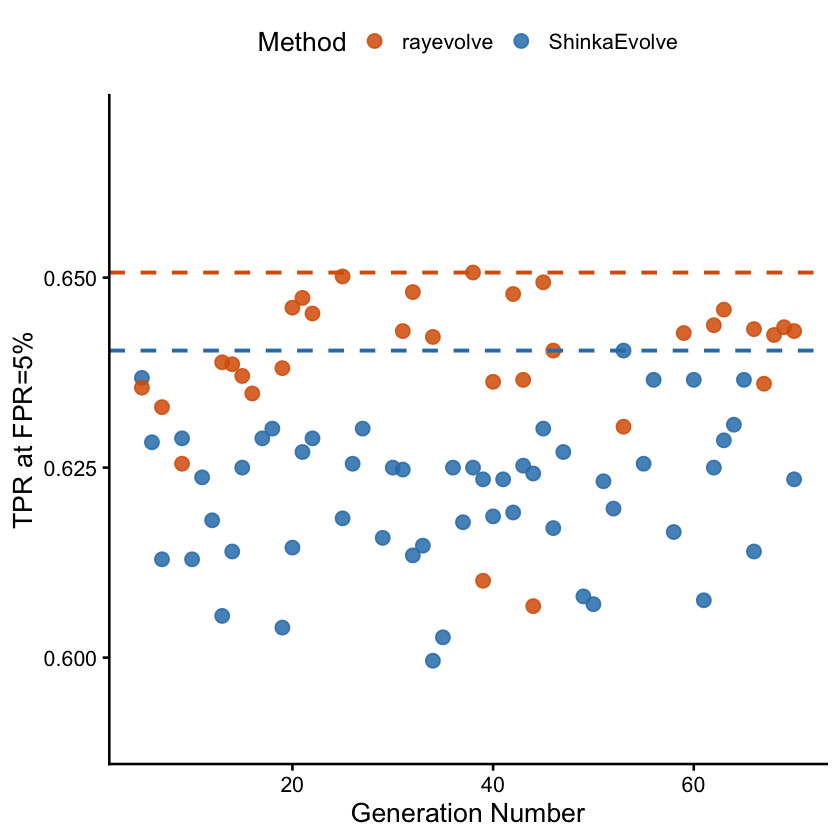

In [9]:
# Compare UCI Adult combined_score across sources
# Use explicit type coercion to handle parquet integer64/double columns
shinka_sel <- df_shinka_uci %>%
  dplyr::select(generation, combined_score) %>%
  dplyr::mutate(
    generation = suppressWarnings(as.numeric(generation)),
    combined_score = suppressWarnings(as.numeric(combined_score)),
    source = "ShinkaEvolve"
  ) %>%
  dplyr::filter(!is.na(generation), !is.na(combined_score))

rayevolve_sel <- df_rayevolve_uci %>%
  dplyr::select(generation, combined_score) %>%
  dplyr::mutate(
    generation = suppressWarnings(as.numeric(generation)),
    combined_score = suppressWarnings(as.numeric(combined_score)),
    source = "rayevolve"
  ) %>%
  dplyr::filter(!is.na(generation), !is.na(combined_score))

combined_df <- dplyr::bind_rows(shinka_sel, rayevolve_sel)

# Compute per-source maxima for horizontal reference lines
max_vals <- combined_df %>%
  dplyr::group_by(source) %>%
  dplyr::summarise(max_combined = max(combined_score, na.rm = TRUE), .groups = "drop")

p_uci <- ggplot2::ggplot(
  combined_df,
  ggplot2::aes(x = generation, y = combined_score, color = source)
) +
  ggplot2::geom_point(alpha = 0.85, size = 3.5) +
  # Horizontal lines at per-source maxima (matching colors)
  ggplot2::geom_hline(
    yintercept = max_vals$max_combined[max_vals$source == "rayevolve"],
    color = "#D95F02", linetype = "dashed", size = 1.1
  ) +
  ggplot2::geom_hline(
    yintercept = max_vals$max_combined[max_vals$source == "ShinkaEvolve"],
    color = "#2C7FB8", linetype = "dashed", size = 1.1
  ) +
  ggplot2::labs(
    title = NULL,
    x = "Generation Number",
    y = "TPR at FPR=5%",
    color = "Method"
  ) +
  ggplot2::scale_color_manual(values = c(
    "ShinkaEvolve" = "#2C7FB8",
    "rayevolve" = "#D95F02"
  )) +
  ggplot2::scale_y_continuous(limits = c(0.59, 0.67)) +
  ggplot2::scale_x_continuous(limits = c(5, 70)) +
  ggplot2::theme_classic(base_size = 16) +
  ggplot2::theme(
    axis.line  = ggplot2::element_line(color = "black"),
    axis.ticks = ggplot2::element_line(color = "black"),
    axis.text  = ggplot2::element_text(color = "black"),
    axis.title = ggplot2::element_text(color = "black"),
    legend.position = "top",
    plot.title = ggplot2::element_text(face = "bold")
  )

p_uci